In [2]:
import pandas as pd

file_path = 'Data/Homework3pt1DataCSV.txt'

with open(file_path, 'r') as file:
    data = [line.strip().split() for line in file]
df = pd.DataFrame(data)

df.columns = [f'Point_{i+1}' for i in range(20)]


In [3]:
bins = [50,30]
pos = [3, 6, 1, 2, 4, 7, 5, 8]

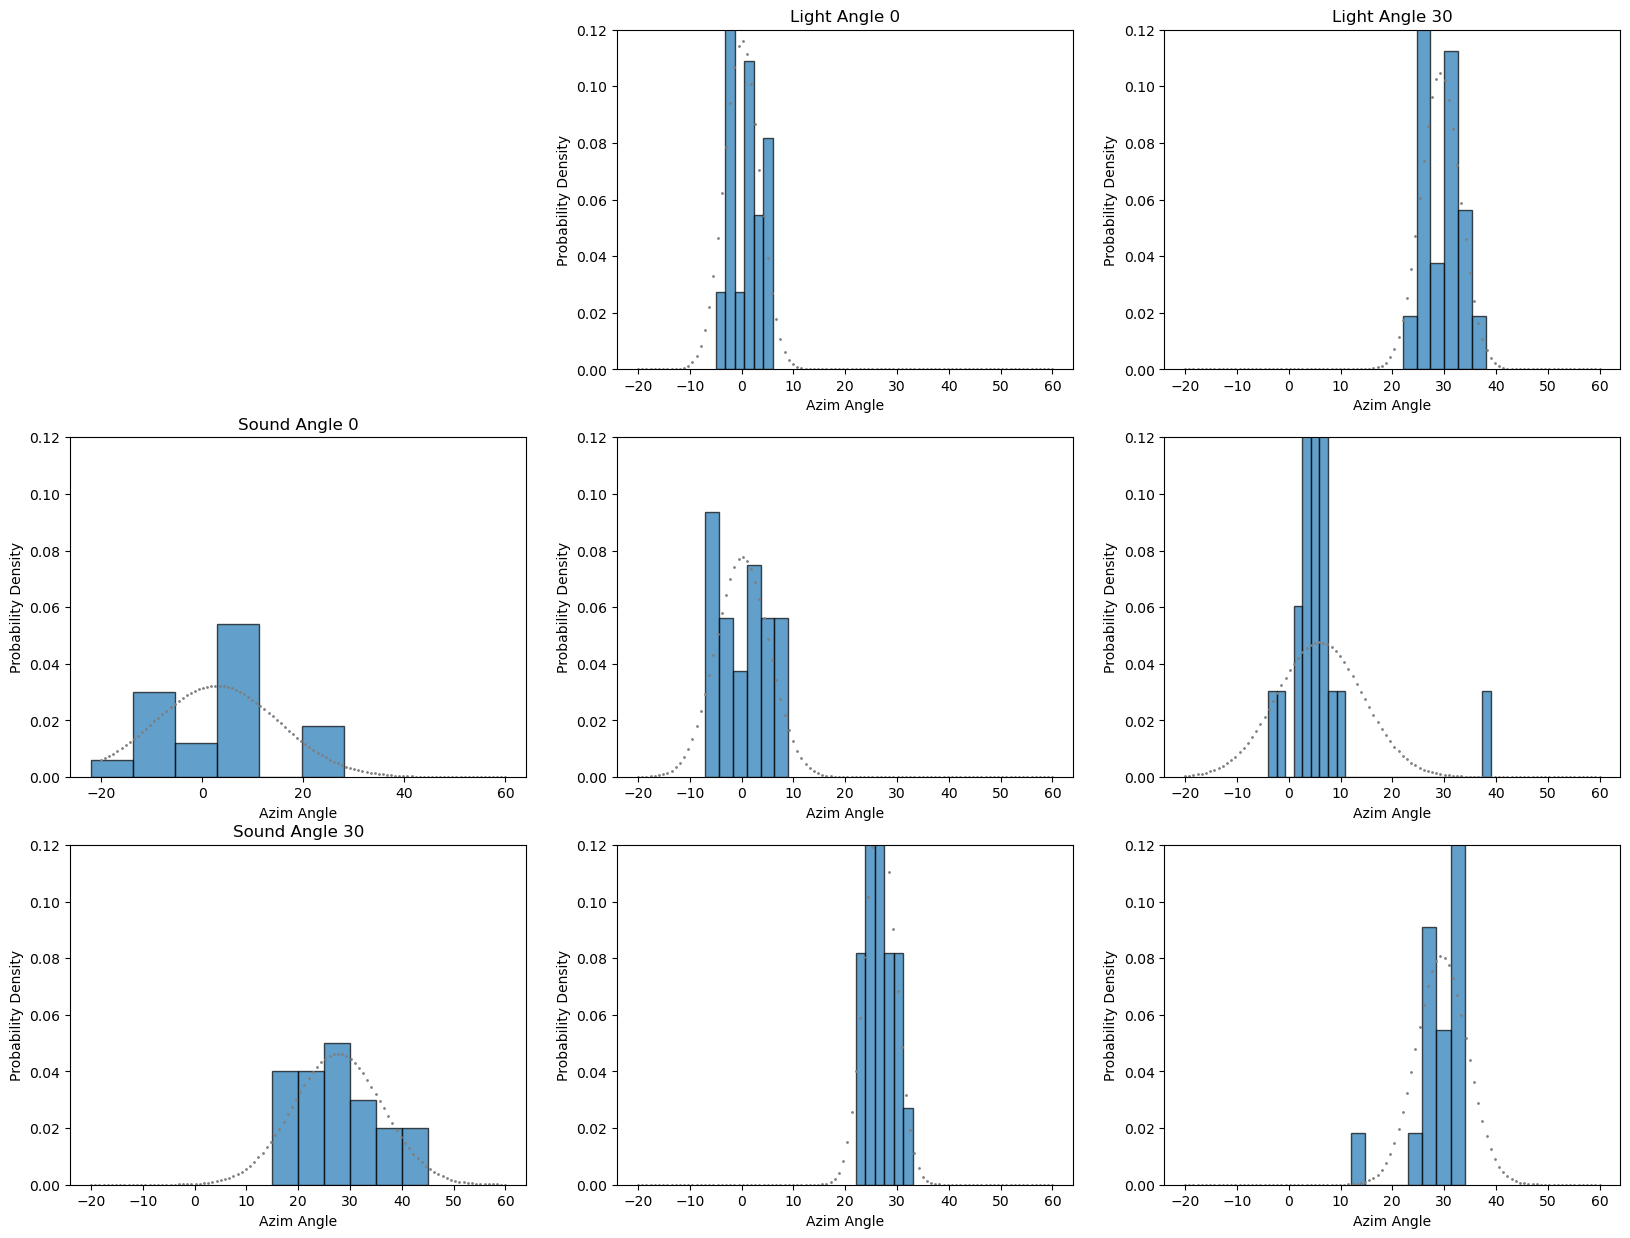

In [4]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

fig, ax = plt.subplots(3, 3, figsize=(20, 15))
ax = ax.flatten()
pos = [3, 6, 1, 2, 4, 7, 5, 8]
ax[0].axis('off')
for i in range(len(df)):
    
    row = pd.to_numeric(df.iloc[i])
    mean = row.mean()
    std_dev = row.std()

    x_values = np.linspace(-20, 60, 100)

    # Calculate the Gaussian distribution (PDF) for these x values
    gaussian_curve = norm.pdf(x_values, mean, std_dev)

    ax[pos[i]].plot(x_values, gaussian_curve, 'o', color='grey', markersize =1, label='Gaussian Distribution')

    ax[pos[i]].hist(row, bins='auto', density=True, alpha=0.7, edgecolor='black')
    ax[pos[i]].set_yticks(np.arange(0, 0.13, 0.02))
    ax[pos[i]].set_ylim(0, 0.12)
    ax[pos[i]].set_xlabel('Azim Angle')
    ax[pos[i]].set_ylabel('Probability Density')
    # plt.xticks([-25, 60])
    if pos[i] == 1:
        ax[pos[i]].set_title('Light Angle 0')
    elif pos[i] == 2:
        ax[pos[i]].set_title('Light Angle 30')
    elif pos[i] == 3:
        ax[pos[i]].set_title('Sound Angle 0')
    elif pos[i] == 6:
        ax[pos[i]].set_title('Sound Angle 30')
plt.show()

The log likelihood is:


$$log P(d | w) = -\frac{N}{2} \log (2 \pi \sigma^2) - \frac{1}{2 \sigma^2} \sum_{n=1}^N (d_n - \mu)^2$$


In [5]:

from scipy.optimize import minimize
import math

N = 20

def miu(sigma_a, sigma_v, mean_a, mean_v):
    return (sigma_v**2 /(sigma_a**2 + sigma_v**2)) * mean_a + (sigma_a**2 /(sigma_a**2 + sigma_v**2)) *mean_v

def sig(sigma_a, sigma_v):
    return math.sqrt((sigma_a**2 * sigma_v**2) / (sigma_a**2 + sigma_v**2))

def log_likelihood(sigma, mean, d):
    return N / 2 * np.log(2 * np.pi * sigma**2) + (1 / (2 * sigma**2)) * np.sum((d - mean)**2)

# Define the negative log likelihood function
def negative_log_likelihood(params, df):
    sigma_a, sigma_v, mean_a0 , mean_a30, mean_v0, mean_v30 = params
    if sigma_a <= 0 or sigma_v<=0:  
        return np.inf
    #nll = N / 2 * np.log(2 * np.pi * sigma**2) + (1 / (2 * sigma**2)) * np.sum((d - mu)**2)
    a0 = pd.to_numeric(df.iloc[0])
    aud0 = log_likelihood(sigma_a, mean_a0, a0)
    a30 = pd.to_numeric(df.iloc[1])
    aud30 = log_likelihood(sigma_a, mean_a30, a30) 
    v0 = pd.to_numeric(df.iloc[2])
    vis0 = log_likelihood(sigma_v, mean_v0, v0)
    v30 = pd.to_numeric(df.iloc[3])
    vis30 = log_likelihood(sigma_v, mean_v30, v30)

    sigav = sig(sigma_a, sigma_v)
    a0v0 = pd.to_numeric(df.iloc[4])
    mean_00 = miu(sigma_a, sigma_v, mean_a0, mean_v0)
    aud0vis0 = log_likelihood(sigav, mean_00, a0v0)
    
    a0v30 = pd.to_numeric(df.iloc[5])
    mean_030 = miu(sigma_a, sigma_v, mean_a0, mean_v30)
    aud0vis30 = log_likelihood(sigav, mean_030, a0v30)

    a30v0 = pd.to_numeric(df.iloc[6])
    mean_300 = miu(sigma_a, sigma_v, mean_a30, mean_v0)
    aud30vis0 = log_likelihood(sigav, mean_300, a30v0)
    
    a30v30 = pd.to_numeric(df.iloc[7])
    mean_3030 = miu(sigma_a, sigma_v, mean_a30, mean_v30)
    aud30vis30 = log_likelihood(sigav, mean_3030, a30v30)
    return (aud0 + aud30 + vis0 + vis30 + aud0vis0 + aud0vis30 + aud30vis0 + aud30vis30)

# Initial guesses for mu and sigma
# parameters : sigma_a, sigma_v, mean_a0 , mean_a30, mean_v0, mean_v30
params = [1, 2, 1, 2, 3, 4]

result = minimize(negative_log_likelihood, params, args=df) 


print("Log Likelihood:", result.fun, "Square Sigma_a:", result.x[0]**2)


Log Likelihood: 517.0605936101812 Square Sigma_a: 132.44285534551113


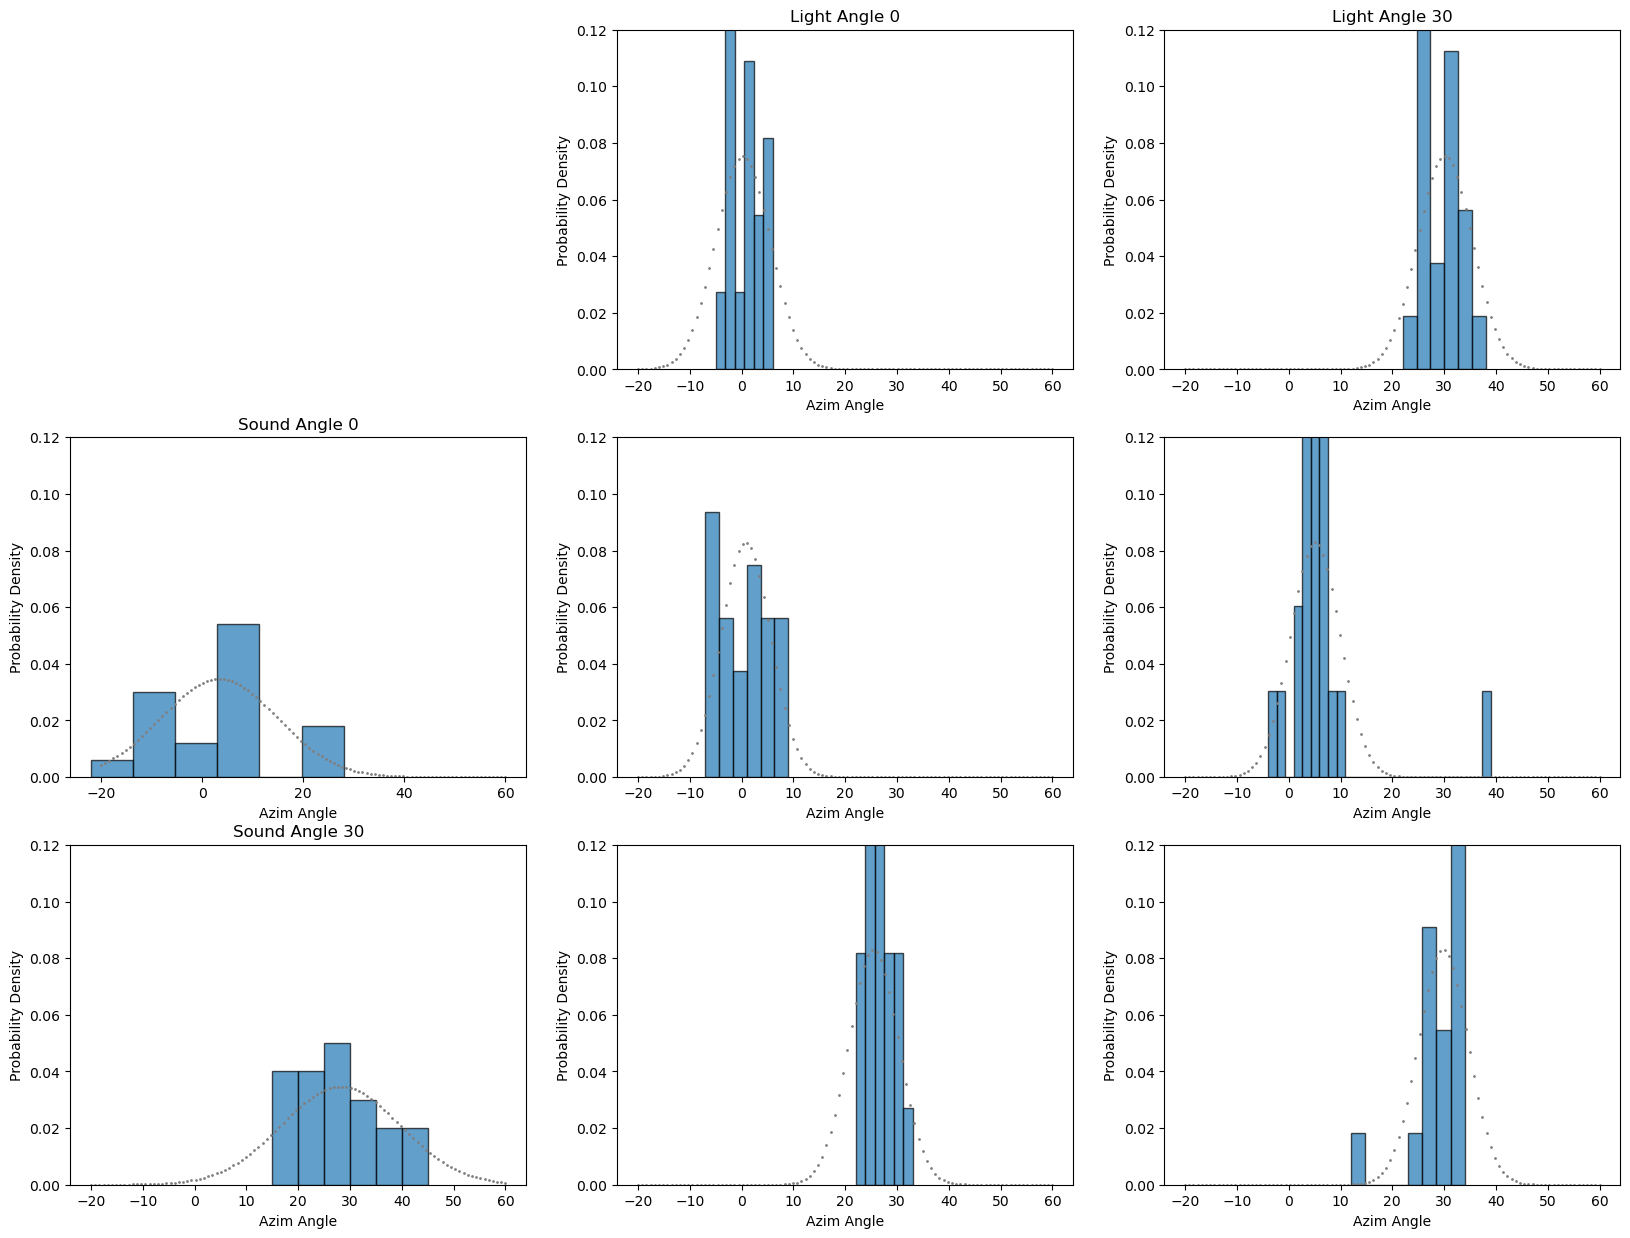

In [6]:
sigma_a, sigma_v, mean_a0 , mean_a30, mean_v0, mean_v30 = result.x
fig, ax = plt.subplots(3, 3, figsize=(20, 15))
ax = ax.flatten()
pos = [3, 6, 1, 2, 4, 7, 5, 8]
sigav = sig(sigma_a, sigma_v)
pars = [[sigma_a, mean_a0],
        [sigma_a, mean_a30],
        [sigma_v, mean_v0], 
        [sigma_v, mean_v30], 
        [sigav, miu(sigma_a, sigma_v, mean_a0, mean_v0)], 
        [sigav, miu(sigma_a, sigma_v, mean_a0, mean_v30)], 
        [sigav, miu(sigma_a, sigma_v, mean_a30, mean_v0)], 
        [sigav, miu(sigma_a, sigma_v, mean_a30, mean_v30)]]
ax[0].axis('off')
for i in range(len(df)):
    
    row = pd.to_numeric(df.iloc[i])
    mean = pars[i][1]
    std_dev = pars[i][0]

    x_values = np.linspace(-20, 60, 100)

    # Calculate the Gaussian distribution (PDF) for these x values
    gaussian_curve = norm.pdf(x_values, mean, std_dev)

    ax[pos[i]].plot(x_values, gaussian_curve, 'o', color='grey', markersize =1, label='Gaussian Distribution')

    ax[pos[i]].hist(row, bins='auto', density=True, alpha=0.7, edgecolor='black')
    ax[pos[i]].set_yticks(np.arange(0, 0.13, 0.02))
    ax[pos[i]].set_ylim(0, 0.12)
    ax[pos[i]].set_xlabel('Azim Angle')
    ax[pos[i]].set_ylabel('Probability Density')
    # plt.xticks([-25, 60])
    if pos[i] == 1:
        ax[pos[i]].set_title('Light Angle 0')
    elif pos[i] == 2:
        ax[pos[i]].set_title('Light Angle 30')
    elif pos[i] == 3:
        ax[pos[i]].set_title('Sound Angle 0')
    elif pos[i] == 6:
        ax[pos[i]].set_title('Sound Angle 30')
plt.show()

Total Validation Error across all 8 folds: 545.7998416058228


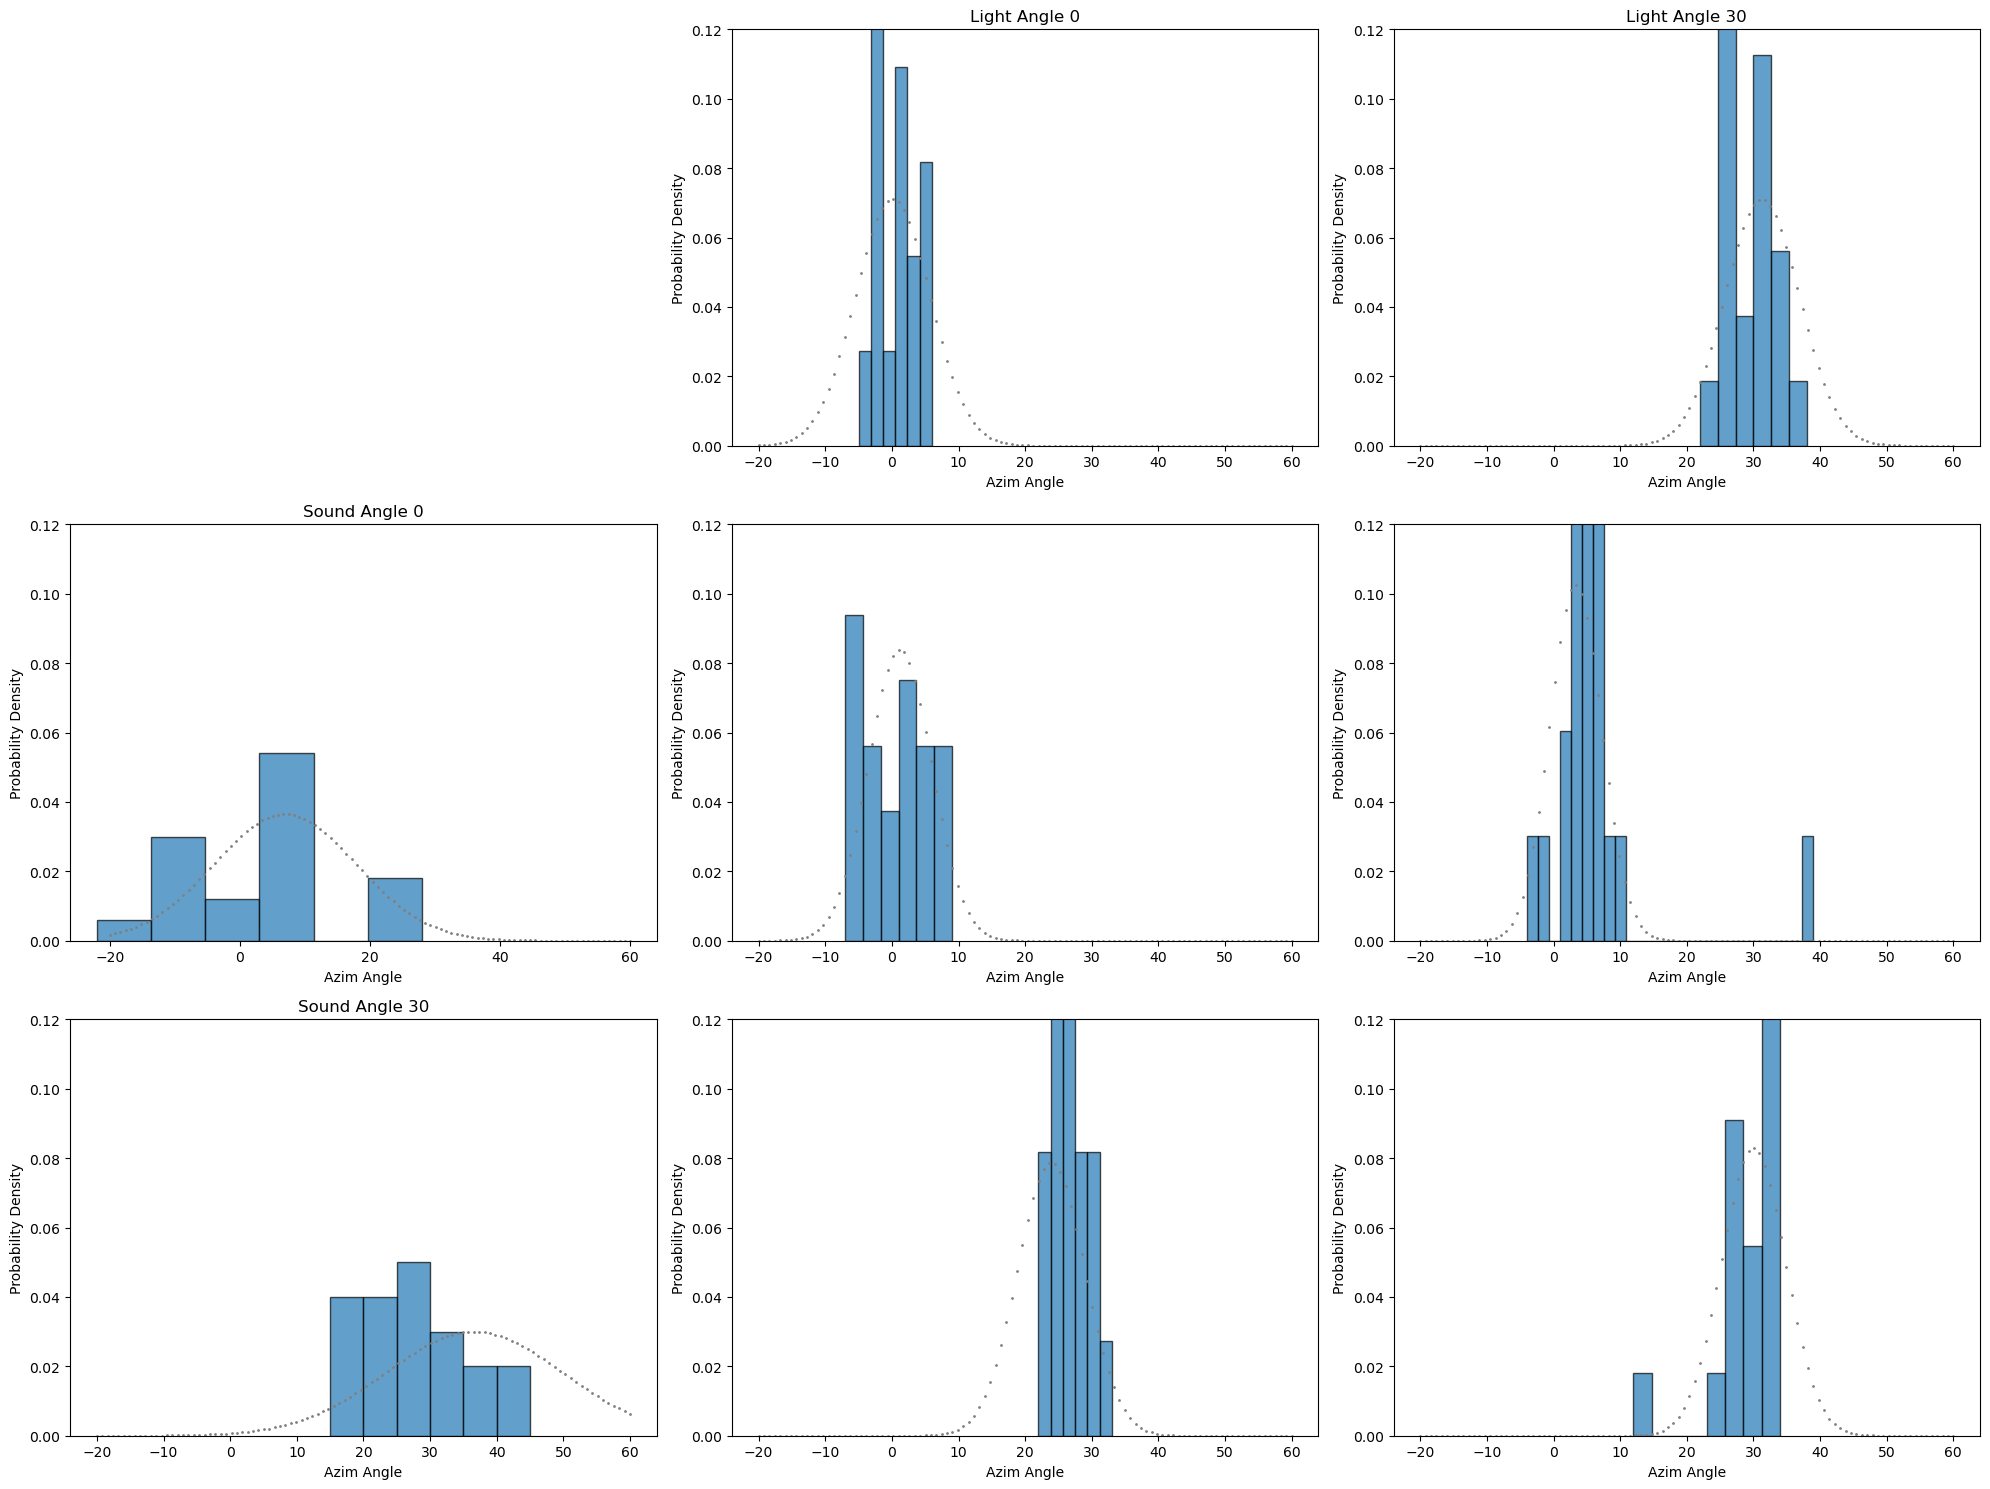

In [29]:
# Define the negative log likelihood function
def negative_log_likelihood(params, df, test):
    sigma_a, sigma_v, mean_a0 , mean_a30, mean_v0, mean_v30 = params
    aud0 = aud30 = vis0 = vis30 = aud0vis0 = aud0vis30 = aud30vis0 = aud30vis30 = 0
    
    if sigma_a <= 0 or sigma_v<=0:  
        return np.inf
    #nll = N / 2 * np.log(2 * np.pi * sigma**2) + (1 / (2 * sigma**2)) * np.sum((d - mu)**2)
    if test != 0:
        a0 = pd.to_numeric(df.iloc[0])
        aud0 = log_likelihood(sigma_a, mean_a0, a0)
    if test != 1:
        a30 = pd.to_numeric(df.iloc[1])
        aud30 = log_likelihood(sigma_a, mean_a30, a30) 
    if test != 2: 
        v0 = pd.to_numeric(df.iloc[2])
        vis0 = log_likelihood(sigma_v, mean_v0, v0)
    if test != 3:     
        v30 = pd.to_numeric(df.iloc[3])
        vis30 = log_likelihood(sigma_v, mean_v30, v30)

    sigav = sig(sigma_a, sigma_v)
    if test != 4: 
        a0v0 = pd.to_numeric(df.iloc[4])
        mean_00 = miu(sigma_a, sigma_v, mean_a0, mean_v0)
        aud0vis0 = log_likelihood(sigav, mean_00, a0v0)
    
    if test != 5:
        a0v30 = pd.to_numeric(df.iloc[5])
        mean_030 = miu(sigma_a, sigma_v, mean_a0, mean_v30)
        aud0vis30 = log_likelihood(sigav, mean_030, a0v30)

    if test != 6:
        a30v0 = pd.to_numeric(df.iloc[6])
        mean_300 = miu(sigma_a, sigma_v, mean_a30, mean_v0)
        aud30vis0 = log_likelihood(sigav, mean_300, a30v0)
    
    if test != 7:
        a30v30 = pd.to_numeric(df.iloc[7])
        mean_3030 = miu(sigma_a, sigma_v, mean_a30, mean_v30)
        aud30vis30 = log_likelihood(sigav, mean_3030, a30v30)
    return (aud0 + aud30 + vis0 + vis30 + aud0vis0 + aud0vis30 + aud30vis0 + aud30vis30)


# Initial guesses for mu and sigma
# parameters : sigma_a, sigma_v, mean_a0 , mean_a30, mean_v0, mean_v30
params = [1, 2, 1, 2, 3, 4]

from sklearn.model_selection import LeaveOneOut
leave =LeaveOneOut()

total_validation_error = 0

fig, ax = plt.subplots(3, 3, figsize=(20, 15))
ax = ax.flatten()
pos = [3, 6, 1, 2, 4, 7, 5, 8]
ax[0].axis('off')

for train_index, test_index in leave.split(df):
    test_index = test_index[0]
    result = minimize(negative_log_likelihood, params, args=(df, test_index))
    
    sigma_a, sigma_v, mean_a0, mean_a30, mean_v0, mean_v30 = result.x
    
    sigav = sig(sigma_a, sigma_v)
    pars = [[sigma_a, mean_a0],
            [sigma_a, mean_a30],
            [sigma_v, mean_v0], 
            [sigma_v, mean_v30], 
            [sigav, miu(sigma_a, sigma_v, mean_a0, mean_v0)], 
            [sigav, miu(sigma_a, sigma_v, mean_a0, mean_v30)], 
            [sigav, miu(sigma_a, sigma_v, mean_a30, mean_v0)], 
            [sigav, miu(sigma_a, sigma_v, mean_a30, mean_v30)]]
    
    validation_data = pd.to_numeric(df.iloc[test_index])
    if test_index == 0:
        validation_error = log_likelihood(sigma_a, mean_a0, validation_data)
    elif test_index == 1:
        validation_error = log_likelihood(sigma_a, mean_a30, validation_data)
    elif test_index == 2:
        validation_error = log_likelihood(sigma_v, mean_v0, validation_data)
    elif test_index == 3:
        validation_error = log_likelihood(sigma_v, mean_v30, validation_data)
    elif test_index == 4:
        validation_error = log_likelihood(sigav, miu(sigma_a, sigma_v, mean_a0, mean_v0), validation_data)
    elif test_index == 5:
        validation_error = log_likelihood(sigav, miu(sigma_a, sigma_v, mean_a0, mean_v30), validation_data)
    elif test_index == 6:
        validation_error = log_likelihood(sigav, miu(sigma_a, sigma_v, mean_a30, mean_v0), validation_data)
    elif test_index == 7:
        validation_error = log_likelihood(sigav, miu(sigma_a, sigma_v, mean_a30, mean_v30), validation_data)
    total_validation_error += validation_error
    
    row = pd.to_numeric(df.iloc[test_index])
    mean = pars[test_index][1]
    std_dev = pars[test_index][0]

    x_values = np.linspace(-20, 60, 100)

    # Calculate the Gaussian distribution (PDF) for these x values
    gaussian_curve = norm.pdf(x_values, mean, std_dev)

    ax[pos[test_index]].plot(x_values, gaussian_curve, 'o', color='grey', markersize =1, label='Gaussian Distribution')

    ax[pos[test_index]].hist(row, bins='auto', density=True, alpha=0.7, edgecolor='black')
    ax[pos[test_index]].set_yticks(np.arange(0, 0.13, 0.02))
    ax[pos[test_index]].set_ylim(0, 0.12)
    ax[pos[test_index]].set_xlabel('Azim Angle')
    ax[pos[test_index]].set_ylabel('Probability Density')

    if pos[test_index] == 1:
        ax[pos[test_index]].set_title('Light Angle 0')
    elif pos[test_index] == 2:
        ax[pos[test_index]].set_title('Light Angle 30')
    elif pos[test_index] == 3:
        ax[pos[test_index]].set_title('Sound Angle 0')
    elif pos[test_index] == 6:
        ax[pos[test_index]].set_title('Sound Angle 30')
    
print(f"Total Validation Error across all 8 folds: {total_validation_error}")
plt.tight_layout()
plt.show()